In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings

warnings.filterwarnings("ignore")

# Training a Model to Predict if the tender will be rejected or not

**Problem:** The _shipper_ wants to know if they can book the bid safely without a tender rejection

- If not, he might want to book another bid.
- If yes, he might want to the bid and wait and see.

**Solution:** We will train a model to predict the chance of the tender being rejected, given
the information we have at the time of the bid. We will also add a simpler model that gives priority to
the past tender rejection proportion to the model, which will call it a "metric" (to be coherent with product).

**Opportunity:** The shipper can use this model to mitigate losses and improve their
operational efficiency. The longer the tendering process takes, the higher the cost
to move the load will be.

**Data:** We will look only at bids tendered.

**Methodology:** We will train a series of very simple models and use a time-series
cross-validation to respect the time component of the data.


## Preparing the data


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn import set_config

set_config(transform_output="pandas")

For this model,we have only a 10th or the data, so I will remove a few features.

We will remove zip3 and kma from this model, as it can lead to bias for certain carriers and shippers that dominate a single region.


In [5]:
feature_columns = [
    "sqr_quote_created",
    "quote_type",
    "equipment_type",
    # "origin_zip3",
    # "origin_kma",
    "origin_state",
    "origin_country",
    # "dest_zip3",
    # "dest_kma",
    "dest_state",
    "dest_country",
    "shipper_plan",
    "shipper_origin",
    "quoting_channel",
    "flat_rate",
    "mileage",
    "lane_type",
    "award_type",
    "service_level",
    "origin_type",
    "load_channel",
    "rpm",
    "days_en_route",
    "del_b4_pu",
    "is_weekend_pickup",
    "delivery_date_epoch",
    "pickup_date_epoch",
    "is_weekend_delivery",
    "is_next_day_trip",
    "is_next_week_trip",
    "is_weekend_trip",
    "lead_time_quote",
    "lead_time_rate",
    "quote_age",
    "pickup_date_year",
    "pickup_date_month",
    "pickup_date_quarter",
    "pickup_date_week",
    "pickup_date_day",
    "pickup_date_hour",
    "pickup_date_dow",
    "pickup_date_doy",
    "pickup_date_is_holiday",
    "pickup_date_month_start",
    "pickup_date_month_end",
    "pickup_date_weekend",
    "delivery_date_year",
    "delivery_date_month",
    "delivery_date_quarter",
    "delivery_date_week",
    "delivery_date_day",
    "delivery_date_hour",
    "delivery_date_dow",
    "delivery_date_doy",
    "delivery_date_is_holiday",
    "delivery_date_month_start",
    "delivery_date_month_end",
    "delivery_date_weekend",
    "sqr_quote_created_year",
    "sqr_quote_created_month",
    "sqr_quote_created_quarter",
    "sqr_quote_created_week",
    "sqr_quote_created_day",
    "sqr_quote_created_hour",
    "sqr_quote_created_dow",
    "sqr_quote_created_doy",
    "sqr_quote_created_is_holiday",
    "sqr_quote_created_month_start",
    "sqr_quote_created_month_end",
    "sqr_quote_created_weekend",
    "sqr_quote_created_epoch",
    "rate_date_year",
    "rate_date_month",
    "rate_date_quarter",
    "rate_date_week",
    "rate_date_day",
    "rate_date_hour",
    "rate_date_dow",
    "rate_date_doy",
    "rate_date_is_holiday",
    "rate_date_month_start",
    "rate_date_month_end",
    "rate_date_weekend",
    "rate_date_epoch",
    "flat_rate_mean",
    "flat_rate_std",
    "flat_rate_median",
    "flat_rate_min",
    "flat_rate_max",
    "flat_rate_count",
    "rate_above_mean",
    "rate_above_median",
    "rate_is_currently_lowest",
    "rate_is_currently_high",
    "tender_sent_at_year",
    "tender_sent_at_month",
    "tender_sent_at_quarter",
    "tender_sent_at_week",
    "tender_sent_at_day",
    "tender_sent_at_hour",
    "tender_sent_at_dow",
    "tender_sent_at_doy",
    "tender_sent_at_is_holiday",
    "tender_sent_at_month_start",
    "tender_sent_at_month_end",
    "tender_sent_at_weekend",
    "tender_sent_at_epoch",
    "tender_age",
    "lead_time_tender",
    "is_rejection_mean",
    "is_rejection_std",
    "is_rejection_median",
    "is_rejection_sum",
    "is_rejection_mean_15",
    "is_rejection_mean_50",
    "is_rejection_mean_70",
    "is_rejection_mean_90",
    "is_rejection_median_15",
    "is_rejection_median_50",
    "is_rejection_median_70",
    "is_rejection_median_90",
    "is_rejection",
]

In [6]:
features_all = pd.read_parquet("data/tender_features.parquet")

In [7]:
features_all.rate_carrier_id

2220    17745
1469    14581
3983    35850
1464    17745
3870    35960
        ...  
5555    46861
5634    58816
5636    66994
5637    59913
5638    65265
Name: rate_carrier_id, Length: 5640, dtype: int64

In [8]:
features = features_all[feature_columns].copy()

In [9]:
features

,sqr_quote_created,quote_type,equipment_type,origin_state,origin_country,dest_state,dest_country,shipper_plan,shipper_origin,quoting_channel,...,is_rejection_sum,is_rejection_mean_15,is_rejection_mean_50,is_rejection_mean_70,is_rejection_mean_90,is_rejection_median_15,is_rejection_median_50,is_rejection_median_70,is_rejection_median_90,is_rejection
2220,2023-03-01 06:19:40,is_agnostic,DRV,MI,USA,IA,US,saas,migrated from webapp,rfp-backend,...,8.0,True,True,True,True,True,True,True,True,1
1469,2023-04-25 13:34:42,is_agnostic,FBE,MI,USA,GA,USA,saas,migrated from webapp,rfp-backend,...,13.0,True,True,True,True,True,True,True,True,1
3983,2023-02-21 18:41:57,is_agnostic,FBE,KY,US,IN,US,saas,migrated from webapp,rfp-backend,...,4.0,True,True,True,True,True,True,True,True,1
1464,2023-02-17 12:32:41,is_agnostic,DRV,MI,US,MS,US,saas,migrated from webapp,rfp-backend,...,1.0,True,True,True,True,True,True,True,True,1
3870,2023-02-27 15:38:09,is_agnostic,FBE,KY,US,KY,US,saas,migrated from webapp,rfp-backend,...,2.0,True,True,True,True,True,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,2023-04-05 09:36:37,is_agnostic,DRV,FL,USA,FL,USA,saas,migrated from webapp,rfp-backend,...,NaN,False,False,False,False,False,False,False,False,0
5634,2023-04-05 09:20:45,is_agnostic,DRV,FL,USA,FL,USA,saas,migrated from webapp,rfp-backend,...,NaN,False,False,False,False,False,False,False,False,0
5636,2023-06-26 15:10:19,is_agnostic,DRV,TX,USA,TX,USA,saas,migrated from webapp,rfp-backend,...,NaN,False,False,False,False,False,False,False,False,0
5637,2023-05-08 09:25:46,is_agnostic,DRV,TX,USA,TX,USA,saas,migrated from webapp,rfp-backend,...,NaN,False,False,False,False,False,False,False,False,0


In [10]:
# finding features with no variation in the data
constant_col = []
for col in features.columns:
    if features[col].nunique() == 1:
        constant_col.append(col)

In [11]:
constant_col

['quote_type',
 'lane_type',
 'service_level',
 'load_channel',
 'del_b4_pu',
 'pickup_date_year',
 'pickup_date_hour',
 'delivery_date_year',
 'delivery_date_hour',
 'sqr_quote_created_year',
 'rate_date_year',
 'tender_sent_at_year']

In [12]:
features = features.drop(constant_col, axis=1)

In [13]:
# find all non numeric columns and set them as category
numerical_features = []
categorical_features = []
for col in features.columns:
    if features[col].dtype in ["object", "str", "string"]:
        features[col] = features[col].astype("category")
        categorical_features.append(col)
    elif features[col].dtype in ["bool", "boolean", bool]:
        features[col] = features[col].astype(int)
        numerical_features.append(col)
    else:
        numerical_features.append(col)
numerical_features.remove("sqr_quote_created")
numerical_features.remove("is_rejection")

## Quick analysis


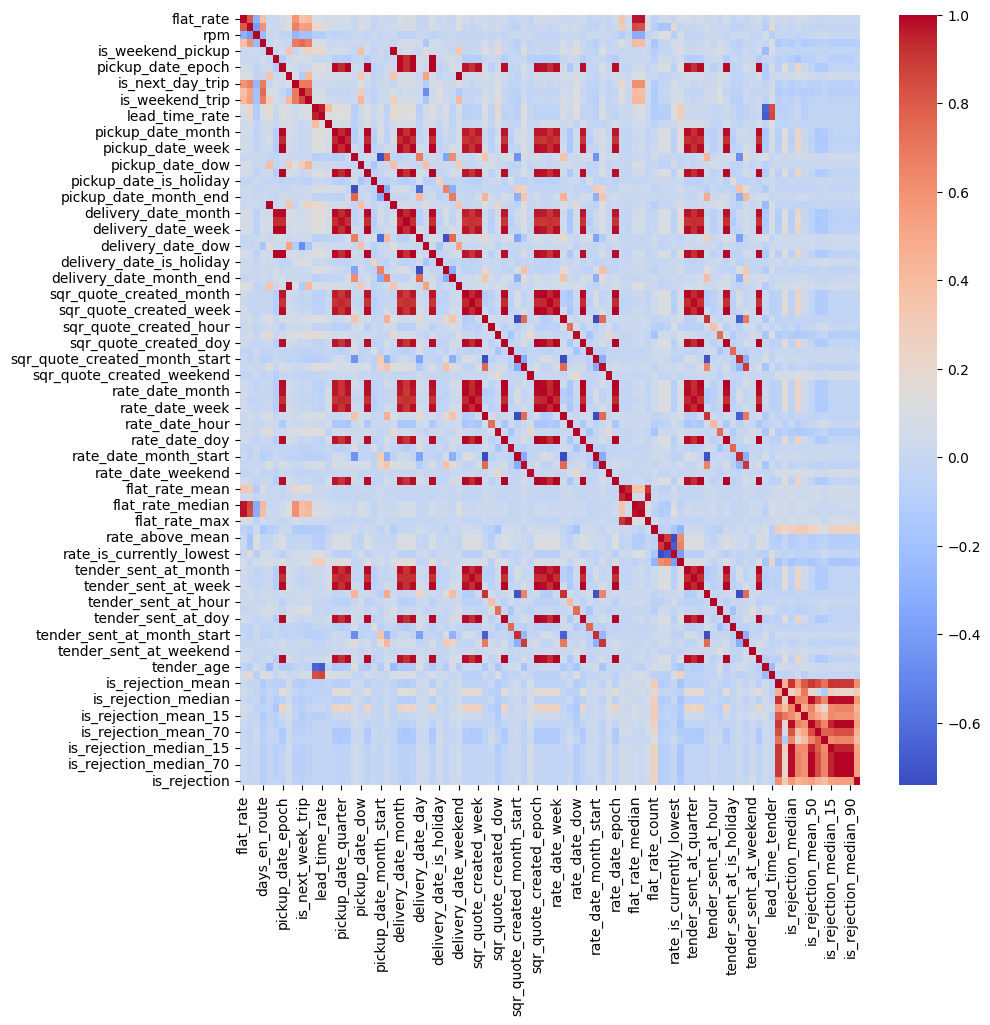

In [14]:
def plot_correlation(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=False, ax=ax, cmap="coolwarm")
    plt.show()


plot_correlation(features)

The last line/column is the target variable.

As we can see, the target variable isn't strongly correlated to any of the variables above.


In [15]:
y = features["is_rejection"].copy(deep=True)

In [16]:
y.value_counts()

0    4548
1    1092
Name: is_rejection, dtype: int64

In [17]:
y.value_counts() / y.shape[0]

0    0.806383
1    0.193617
Name: is_rejection, dtype: float64

In [18]:
X = features.drop(["is_rejection", "sqr_quote_created"], axis=1)

In [19]:
# replace infinity for NaN in the dataframe X
import numpy as np

X = X.replace([np.inf, -np.inf], np.nan)

In [20]:
categorical_features

['equipment_type',
 'origin_state',
 'origin_country',
 'dest_state',
 'dest_country',
 'shipper_plan',
 'shipper_origin',
 'quoting_channel',
 'award_type',
 'origin_type']

## Building the transdformer pipeline

Below we use Sklearn's transformer pipeline to:

- Impute missing values depending on the feature type
- Scale the features using a StandardScaler, which is a requirement to use Logistic Regression.
- Treat categorical features as dummy variables using One Hot Encoding


In [21]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from utils import ConstantImputer
from sklearn.compose import make_column_transformer

SimpleImputer.get_feature_names_out = lambda self, names=None: self.feature_names_in_

numerical_transformer = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_transformer = make_pipeline(
    ConstantImputer(), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
transformer = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
)

In [22]:
results = []

## Using a Dummy Classifier

This classifier will just predict the most frequent class in the training set.

We will get horrible metrics overall, but an accuracy of 64% on the validation.

This highlights why you **must** use many metrics besides accuracy when evaluating
classification, as each one has their trade-offs.


In [23]:
y.value_counts()

0    4548
1    1092
Name: is_rejection, dtype: int64

In [24]:
from utils import time_series_validation


regressor = DummyClassifier(strategy="stratified", random_state=42)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1


Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [25]:
result

,fold,n_train,n_test,f1_train,recall_train,precision_train,roc_auc_train,accuracy_train,f1_validation,recall_validation,precision_validation,roc_auc_validation,accuracy_validation,true_postive_validation,false_postive_validation,true_negative_validation,false_negative_validation
0,0,3607,199,0.217931,0.217931,0.217931,0.510596,0.685611,0.296296,0.307692,0.285714,0.560096,0.713568,0.060302,0.150754,0.653266,0.135678
1,1,3806,181,0.194644,0.195026,0.194263,0.495935,0.676038,0.103896,0.095238,0.114286,0.436108,0.618785,0.022099,0.171271,0.596685,0.209945
2,2,3987,125,0.210006,0.210918,0.209102,0.504390,0.679207,0.230769,0.230769,0.230769,0.514375,0.680000,0.048000,0.160000,0.632000,0.160000
3,3,4112,156,0.211976,0.212740,0.211217,0.505608,0.679961,0.033333,0.037037,0.030303,0.394488,0.628205,0.006410,0.205128,0.621795,0.166667
4,4,4268,232,0.199766,0.199069,0.200469,0.499505,0.679007,0.222222,0.207547,0.239130,0.506008,0.668103,0.047414,0.150862,0.620690,0.181034
5,5,4500,270,0.208791,0.208333,0.209251,0.504111,0.680000,0.156863,0.177778,0.140351,0.480000,0.681481,0.029630,0.181481,0.651852,0.137037
6,6,4770,336,0.199791,0.199582,0.200000,0.499607,0.679245,0.129032,0.140351,0.119403,0.464441,0.678571,0.023810,0.175595,0.654762,0.145833
7,7,5106,190,0.203658,0.203156,0.204163,0.503460,0.684489,0.125000,0.153846,0.105263,0.473265,0.705263,0.021053,0.178947,0.684211,0.115789
8,8,5296,172,0.194297,0.193269,0.195335,0.499360,0.685234,0.161290,0.172414,0.151515,0.488305,0.697674,0.029070,0.162791,0.668605,0.139535
9,9,5468,172,0.192090,0.190833,0.193365,0.498690,0.686174,0.109091,0.130435,0.093750,0.467902,0.715116,0.017442,0.168605,0.697674,0.116279


In [26]:
results_dummy = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)

In [27]:
results_dummy["model"] = "Dummy"
results.append(results_dummy)

results_dummy

,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Dummy
1,n_test,203.300000,61.375076,185.500000,Dummy
2,f1_train,0.203295,0.008635,0.201724,Dummy
3,recall_train,0.203086,0.009082,0.201369,Dummy
4,precision_train,0.203510,0.008225,0.202316,Dummy
5,roc_auc_train,0.502126,0.004291,0.501534,Dummy
6,accuracy_train,0.681497,0.003538,0.679981,Dummy
7,f1_validation,0.156779,0.075522,0.142948,Dummy
8,recall_validation,0.165311,0.074448,0.163130,Dummy
9,precision_validation,0.151048,0.077942,0.129877,Dummy


## Using Logistic Regression

We will use the logistic regression with all features, even the uncorrelated ones.

This will give better results from compared to the previous model, with not signs of overfitting.

But because we have too many unrelated variables, the model will use L2 regularization to reduce the weights of the unrelated variables.


In [28]:
regressor = LogisticRegression(penalty="l2", n_jobs=-1, random_state=42, max_iter=1000)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0


Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [29]:
results_logit = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit["model"] = "Logistic Regression (Logit)"
results.append(results_logit)
results_logit

,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Logistic Regression (Logit)
1,n_test,203.300000,61.375076,185.500000,Logistic Regression (Logit)
2,f1_train,0.767414,0.005145,0.765314,Logistic Regression (Logit)
3,recall_train,0.670995,0.010136,0.670216,Logistic Regression (Logit)
4,precision_train,0.896416,0.007806,0.895247,Logistic Regression (Logit)
5,roc_auc_train,0.933716,0.004714,0.935490,Logistic Regression (Logit)
6,accuracy_train,0.918626,0.001239,0.918826,Logistic Regression (Logit)
7,f1_validation,0.649506,0.183401,0.645190,Logistic Regression (Logit)
8,recall_validation,0.531366,0.192195,0.515520,Logistic Regression (Logit)
9,precision_validation,0.873235,0.159465,0.942708,Logistic Regression (Logit)


### Top 10 features


In [30]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
205,pipeline-2__origin_type_missing,[4.598350091660105]
207,pipeline-2__origin_type_spot_quote,[-2.406785422677146]
206,pipeline-2__origin_type_shipment,[-2.186902463914096]
116,pipeline-2__origin_state_MI,[-1.6956503328843182]
69,pipeline-1__tender_sent_at_quarter,[1.384657182368518]
111,pipeline-2__origin_state_KY,[1.2788063815924657]
137,pipeline-2__origin_state_VT,[1.210194086227155]
179,pipeline-2__dest_state_OR,[1.169240768249605]
149,pipeline-2__dest_state_CT,[1.0881099408207517]
189,pipeline-2__dest_state_VT,[-1.0062404109492573]


## Removing weak features using ANOVA

I'll just keep 20 features with the best F-value from the ANOVA, this will remove the features with weak effects on the target variable.


In [31]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

selector = SelectKBest(f_classif, k=30)
var_selector = VarianceThreshold(threshold=0.00)

pipe = make_pipeline(transformer, selector, var_selector, regressor)

In [32]:
result = time_series_validation(X, y, base_data=features, model=pipe)
results_logit_sel = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit_sel["model"] = "Logit + Selection"
results.append(results_logit_sel)
results_logit_sel

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Logit + Selection
1,n_test,203.300000,61.375076,185.500000,Logit + Selection
2,f1_train,0.743491,0.005855,0.744154,Logit + Selection
3,recall_train,0.631222,0.011312,0.634609,Logit + Selection
4,precision_train,0.904676,0.009213,0.907742,Logit + Selection
5,roc_auc_train,0.907609,0.003976,0.908797,Logit + Selection
6,accuracy_train,0.912867,0.000941,0.913119,Logit + Selection
7,f1_validation,0.614250,0.217593,0.638206,Logit + Selection
8,recall_validation,0.481729,0.201105,0.474696,Logit + Selection
9,precision_validation,0.908014,0.149703,0.957555,Logit + Selection


### Top 10 features


In [33]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
28,pipeline-2__origin_type_missing,[6.488862484558687]
19,pipeline-2__origin_state_MI,[-2.5230635123401335]
24,pipeline-2__dest_state_UT,[0.9193968818576366]
18,pipeline-2__origin_state_IL,[-0.8070843827998861]
6,pipeline-1__is_rejection_mean,[0.6116794299309704]
23,pipeline-2__dest_state_IN,[-0.48639878180342794]
7,pipeline-1__is_rejection_std,[0.41428575802246986]
20,pipeline-2__origin_state_OH,[-0.40531454317662097]
29,pipeline-2__origin_type_shipment,[-0.3353008145440506]
21,pipeline-2__origin_country_US,[0.249798983710355]


## Rebalancing the target variable

Another problem we have is that the dataset is unbalanced. We have only 6% of the rates as the lowest.

Using the parameter `class_weight="balanced"` we will give more weight to the minority
class so the dataset is 50/50


In [34]:
regressor = LogisticRegression(
    class_weight="balanced", n_jobs=-1, random_state=42, max_iter=1000
)
pipe = make_pipeline(transformer, regressor)

result = time_series_validation(X, y, base_data=features, model=pipe)
result_logit_sel_bal = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
result_logit_sel_bal["model"] = "Logit + Balancing"
results.append(result_logit_sel_bal)
result_logit_sel_bal

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Logit + Balancing
1,n_test,203.300000,61.375076,185.500000,Logit + Balancing
2,f1_train,0.748431,0.011778,0.753618,Logit + Balancing
3,recall_train,0.812519,0.011667,0.815998,Logit + Balancing
4,precision_train,0.693726,0.012095,0.697638,Logit + Balancing
5,roc_auc_train,0.937826,0.004778,0.940238,Logit + Balancing
6,accuracy_train,0.890732,0.004031,0.892028,Logit + Balancing
7,f1_validation,0.646383,0.159572,0.670576,Logit + Balancing
8,recall_validation,0.670418,0.174113,0.673618,Logit + Balancing
9,precision_validation,0.646530,0.175437,0.663710,Logit + Balancing


Rebalancing sacrificies precision and accuracy to gain recall. The model is more likely to predict a lowest rate class, but it is also more likely to be wrong when it does so. This is a good trade-off when the cost of false negatives is high.


### Top 10 features


In [35]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
205,pipeline-2__origin_type_missing,[4.614419566880966]
207,pipeline-2__origin_type_spot_quote,[-2.3181233955593488]
206,pipeline-2__origin_type_shipment,[-2.289157612657376]
116,pipeline-2__origin_state_MI,[-1.8800026381374357]
69,pipeline-1__tender_sent_at_quarter,[1.5755295195926056]
179,pipeline-2__dest_state_OR,[1.4775648621694786]
137,pipeline-2__origin_state_VT,[1.3764585960633717]
111,pipeline-2__origin_state_KY,[1.2959807914718906]
189,pipeline-2__dest_state_VT,[-1.243516878108629]
24,pipeline-1__delivery_date_month,[-1.1603872745480077]


In [36]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(20)

,features,coefficients
205,pipeline-2__origin_type_missing,[4.614419566880966]
207,pipeline-2__origin_type_spot_quote,[-2.3181233955593488]
206,pipeline-2__origin_type_shipment,[-2.289157612657376]
116,pipeline-2__origin_state_MI,[-1.8800026381374357]
69,pipeline-1__tender_sent_at_quarter,[1.5755295195926056]
179,pipeline-2__dest_state_OR,[1.4775648621694786]
137,pipeline-2__origin_state_VT,[1.3764585960633717]
111,pipeline-2__origin_state_KY,[1.2959807914718906]
189,pipeline-2__dest_state_VT,[-1.243516878108629]
24,pipeline-1__delivery_date_month,[-1.1603872745480077]


# Metric Classifier + Dummy Classifier


In [37]:
from utils import MetricClassifier, IdTransformer

# add carrier_id back
X_new = X.join(features_all["rate_carrier_id"])


transformer = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
    (
        make_pipeline(IdTransformer()),
        ["tender_sent_at_epoch", "rate_carrier_id", "is_rejection_mean_15"],
    ),
)
regressor = MetricClassifier("is_rejection_mean_15")
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X_new, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [38]:
results_dummy = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_dummy["model"] = "Dummy + Metric (15)"
results.append(results_dummy)

results_dummy

,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Dummy + Metric (15)
1,n_test,203.300000,61.375076,185.500000,Dummy + Metric (15)
2,f1_train,0.649324,0.007865,0.651264,Dummy + Metric (15)
3,recall_train,0.837251,0.005216,0.837620,Dummy + Metric (15)
4,precision_train,0.530401,0.011033,0.534083,Dummy + Metric (15)
5,roc_auc_train,0.825833,0.002711,0.826252,Dummy + Metric (15)
6,accuracy_train,0.818988,0.005562,0.821314,Dummy + Metric (15)
7,f1_validation,0.549094,0.070606,0.543735,Dummy + Metric (15)
8,recall_validation,0.726605,0.120566,0.708020,Dummy + Metric (15)
9,precision_validation,0.453102,0.088957,0.449539,Dummy + Metric (15)


# Metric Classifier + Logit Balanced Classifier


In [39]:
# add carrier_id back
X_new = X.join(features_all["rate_carrier_id"])
regressor = LogisticRegression(
    class_weight="balanced", n_jobs=-1, random_state=42, max_iter=1000
)

transformer = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
    (
        make_pipeline(IdTransformer()),
        ["tender_sent_at_epoch", "rate_carrier_id", "is_rejection_mean_15"],
    ),
)
regressor = MetricClassifier("is_rejection_mean_15", ml_model=regressor)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X_new, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [40]:
results_logit = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit["model"] = "Logit Balanced + Metric (15)"
results.append(results_logit)

results_logit

,metric,mean,std,50%,model
0,n_train,4492.000000,646.078599,4384.000000,Logit Balanced + Metric (15)
1,n_test,203.300000,61.375076,185.500000,Logit Balanced + Metric (15)
2,f1_train,0.649324,0.007865,0.651264,Logit Balanced + Metric (15)
3,recall_train,0.837251,0.005216,0.837620,Logit Balanced + Metric (15)
4,precision_train,0.530401,0.011033,0.534083,Logit Balanced + Metric (15)
5,roc_auc_train,0.825833,0.002711,0.826252,Logit Balanced + Metric (15)
6,accuracy_train,0.818988,0.005562,0.821314,Logit Balanced + Metric (15)
7,f1_validation,0.559007,0.077033,0.558333,Logit Balanced + Metric (15)
8,recall_validation,0.752589,0.127312,0.752747,Logit Balanced + Metric (15)
9,precision_validation,0.455566,0.089678,0.455617,Logit Balanced + Metric (15)


## Comparing results


In [41]:
validation_results = pd.concat(results)
validation_results = validation_results.loc[
    validation_results["metric"].str.contains("_validation"),
    ["model", "metric", "mean", "50%"],
].reset_index(drop=True)

In [42]:
validation_results

,model,metric,mean,50%
0,Dummy,f1_validation,0.156779,0.142948
1,Dummy,recall_validation,0.165311,0.163130
2,Dummy,precision_validation,0.151048,0.129877
3,Dummy,roc_auc_validation,0.478499,0.476632
4,Dummy,accuracy_validation,0.678677,0.680741
5,Dummy,true_postive_validation,0.030523,0.026440
6,Dummy,false_postive_validation,0.170543,0.169938
7,Dummy,true_negative_validation,0.648154,0.652559
8,Dummy,false_negative_validation,0.150780,0.142684
9,Logistic Regression (Logit),f1_validation,0.649506,0.645190


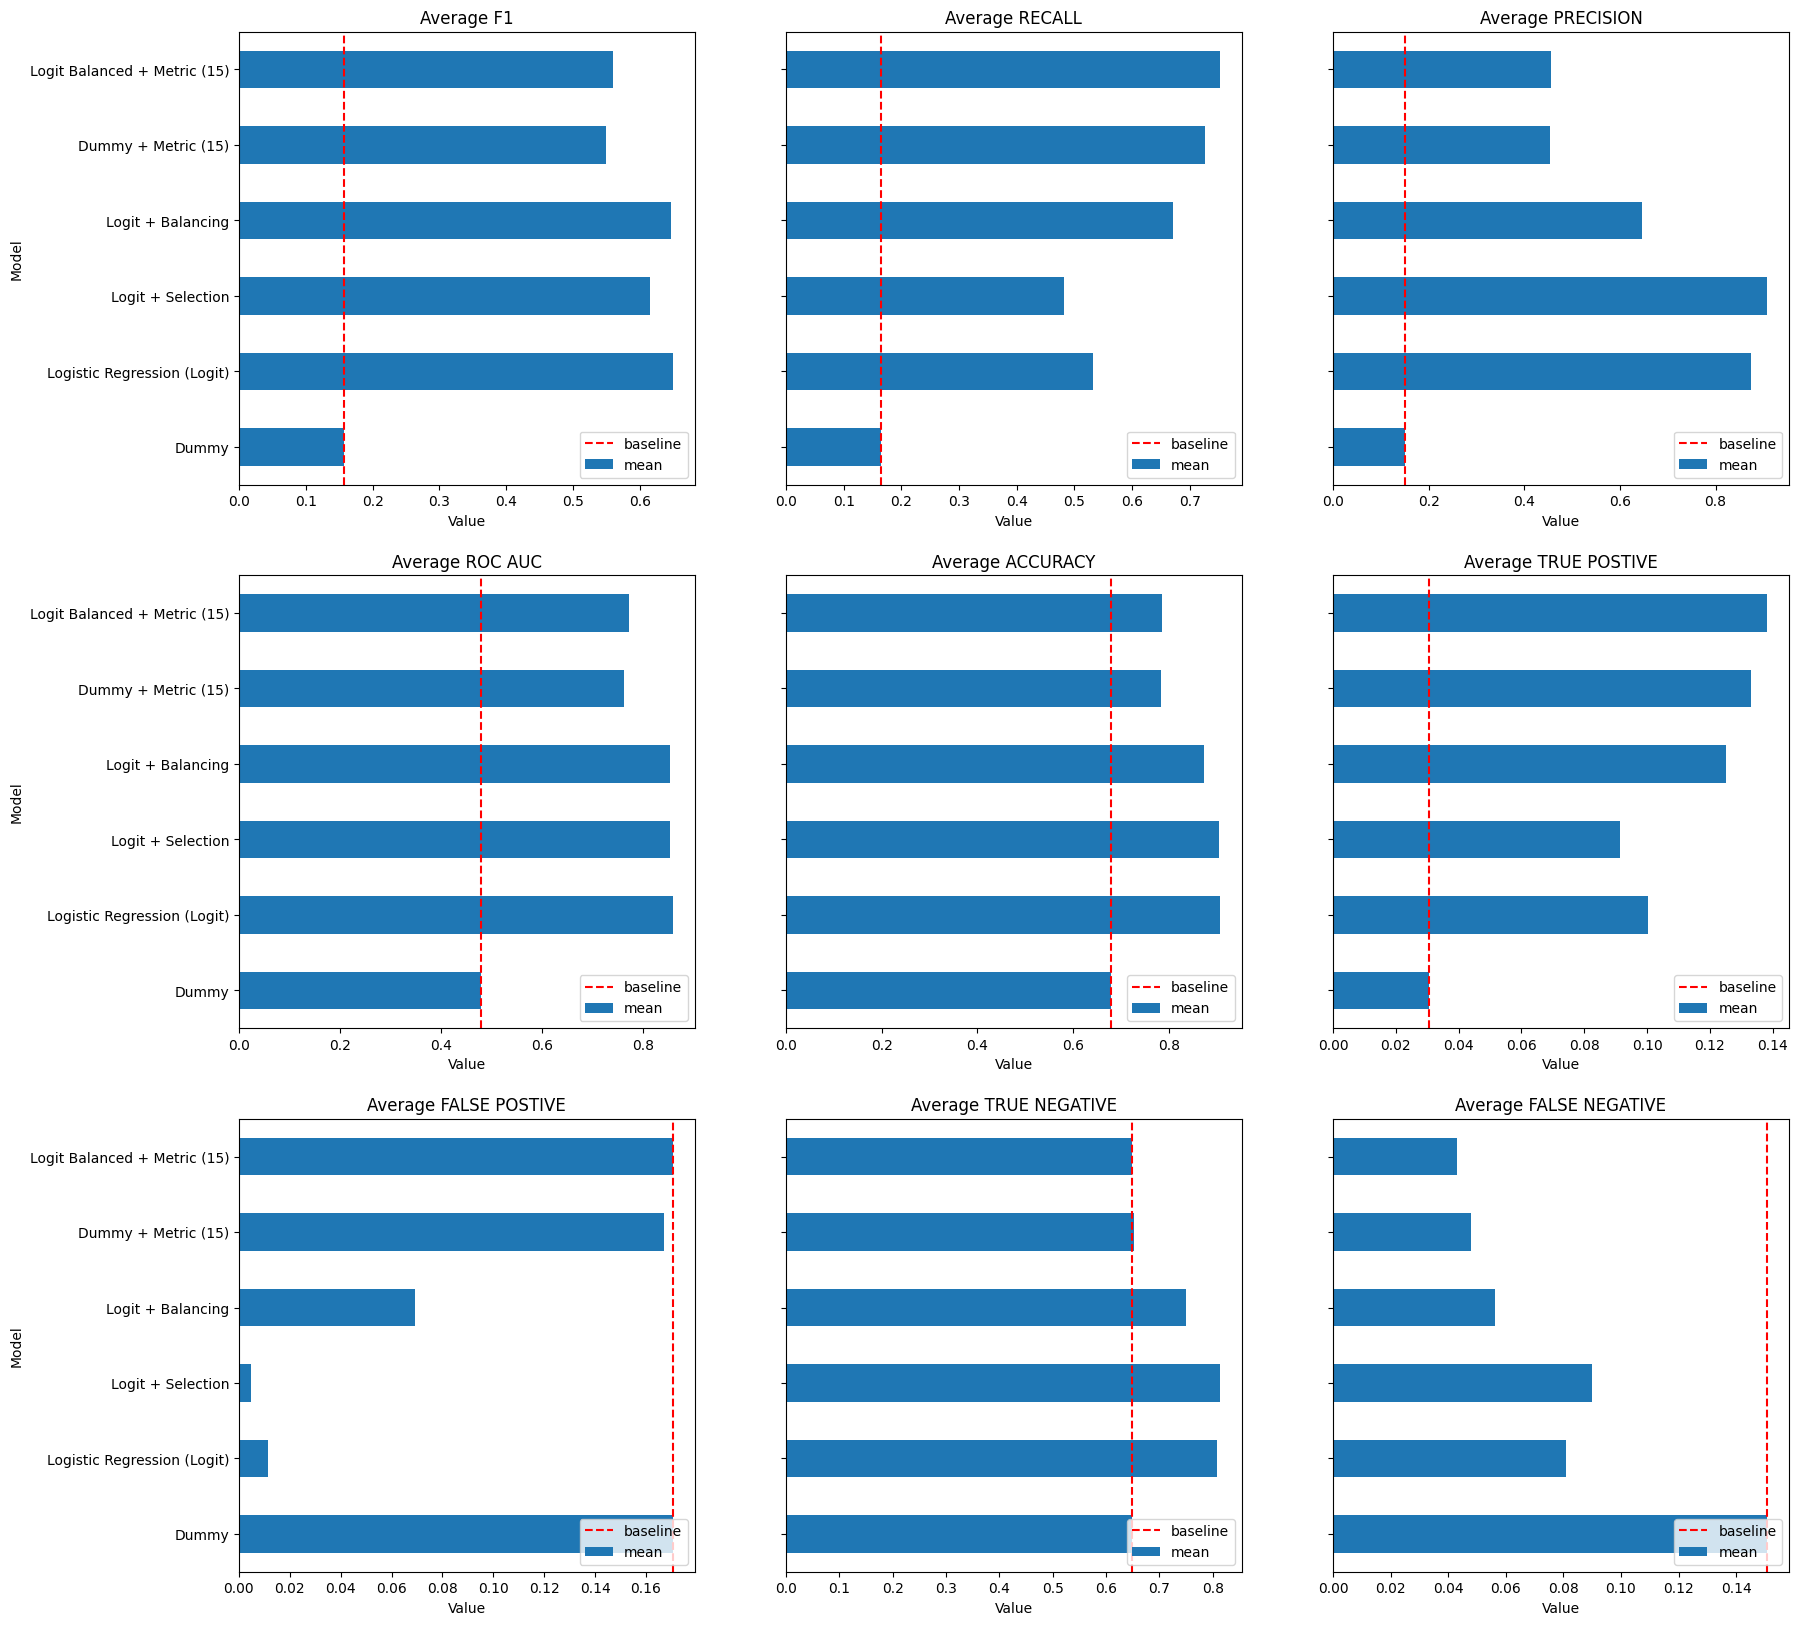

In [43]:
models = validation_results["model"].unique()
metrics = validation_results["metric"].unique()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True)

for metric, ax in zip(metrics, axes.flatten()):
    baseline = validation_results.loc[
        (validation_results["metric"] == metric)
        & (validation_results["model"] == "Dummy"),
        "mean",
    ].values[0]
    ax.axvline(baseline, label="baseline", color="red", linestyle="dashed")
    validation_results[validation_results["metric"] == metric].plot.barh(
        y="mean",
        x="model",
        ax=ax,
        legend=False,
    )
    ax.set_title(
        "Average " + metric.removesuffix("_validation").replace("_", " ").upper()
    )
    ax.set_xlabel("Value")
    ax.set_ylabel("Model")
    ax.legend(loc="lower right")
    # ax.legend(loc="lower right")

We can clearly get gains if we use a Logit Balanced as a model, and we can get
some more gains in False Negative reduction if we use a heuristic based (aka Metric)
on past tender rejection with the model.

This problem requires some caution due to the very low sample size and extremely unbalanced problem.

## Next steps

Same as last two. Add more features, test more models, etc.

In this case we might want to focus on reducing false negatives.
